First of all, it is necessary to equip ourselves with the required packages. 
Please run on your terminal:

                                            `pip install -r requirements.txt`

I'd suggest creating a separate virtual env to do so just to protect everything else you have on your computer. Unfortunately some nasty packages are required and the operation may take a while. Please consider that the `requirements.txt` list includes only few of these packages and while running the notebook it may happen to install additional packages. If possible, reports this packages and update the list. 

In [1]:
import numpy as np
from CIR import get_CIR
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.utils.data as data
import numpy as np
from simulation import Simulation, Contract
from torch.utils.data import TensorDataset, Dataset, DataLoader
import Sandbox_utils as utils
import dataset_managment
import model_managment
import train_managment
import torch_geometric

from GCLSTM import GCLSTM

We will divide our discussion into 2 steps: the first part is model **training**, the second one is related to its evaluation.

# Model Fit

## First steps

First of all we need to fix a 'device' over which we will run our code. I'd suggest using 'cuda' or andother GPU kernel whenever possible, especially when it comes to fitting the model.  

In [2]:
# Fix current device
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"      #MacOS
    if torch.backends.mps.is_available()
    else "cpu"
)

#Unccoment here, is just for Matteo's testing 
device = 'cpu'

print('Device: ', device)

Device:  cpu


It is quite useful to use `argparse` as we can pass a lot of parameters both through a dictionary and a `.yaml` file. Here on the notebook its just a simple dictionary.

In [3]:
import argparse

def dict_to_args(dictionary):
    parser = argparse.ArgumentParser()
    
    for key, value in dictionary.items():
        parser.add_argument(f'--{key}', type=type(value), default=value)
    
    return parser.parse_args([])

In [4]:
#List of multiple parameters used both during simulation and 
args = { 
    # Simulation parameters (Duffie et al. + simulation)
    'alpha' : 0.6,
    'b' : 0.04,
    'sigma' : 0.14,
    'v_0' : 0.04,
    'years' : 60,
    'gamma' : 3,
    
    # Dataset parameters
    'steps_ahead' : 5,                    #Prediction horizon
    'steps_filename' : 1,
    'num_nodes' : 5,                      #Number of nodes in the network    
    'lookback' : 5,                       #Number of historical steps to learn from 
    'train_split' : 0.8,                  #Train/Test split
    
    # Model parameters
    'lstm_hidden_size' : 15,             
    'regressor_hidden_size' : 512,
    'regressor_hidden_size_2' : 512,
    'number_regressor_layers' : 2,
    'input_size' : 36,
    'contract_size' : 6,

    # Training parameters
    'initial_lr' : 0.005, #5e-3
    'n_epochs' : 20000,
    'patience' : 50,
    'scheduler_milestone_frequency' : 130,
    'scheduler_number_of_updates' : 60,
    'scheduler_gamma' : 0.9,
    'validation_every' : 20,
    'batch_size' : 500,

    # Physical device
    'device': 'cpu',
}

args = dict_to_args(args)

## Loading simulation data

Now we load both data coming from the simulation of the synthetic model. The so-called benchmark for each node (i.e.) the best theoretical predictor given the interest rate conditioning  and the graph's data (contract features + adjacency matrix) for each step.
In order to obtain these quantities, please refer to `todo.ipynb` (MISSING)

In [5]:
path_name = '../data/'
data_file_name = path_name + f'subgraphs_Duffie_{args.num_nodes}nodes_3gamma.pt'

In [6]:
try:
    print(f'Retrieving data...')
    dataset = torch.load(path_name + f'subgraphs_Duffie_{args.num_nodes}nodes_3gamma.pt',  map_location=torch.device(device))
    bench = torch.load('../data/y_benchmark_5nodes.pt')
    print(f'Done')

except:
    print('Error: the data file: ',path_name + f'subgraphs_Duffie_{args.num_nodes}nodes_3gamma.pt',' doesnt exist, please run `SimulateNetwork.py`')
    raise ValueError



Retrieving data...
Done


Then we generate the interest rate process with **the same parameters** so that we retain data consistency. We also build a simulation object which will come in handy.

In [7]:
# Generate CIR process & simulation
sim = Simulation(args.alpha, args.b, args.sigma, args.v_0, args.years, gamma = args.gamma, seed=True)
CIRProcess = torch.tensor(sim.CIRProcess.reshape(-1,1)).to(torch.float32).to(device)

Just to be super clear, `dataset` is a list of which each item represent our network for a given day of the simulation horizon. Each item is a `torch_geometric.data` object which stores a graph in terms of its features and the adjacency matrix. For instance, the graph on our 100-th day:

In [8]:
dataset[100]

Data(x=[5, 168], edge_index=[2, 2], y=[5], r=[1], node_feat=[5], num_nodes=5)

Where x is the node feature matrix, edge_index the adjacency matrix, y the target, r the interest rate. `node_feat` is the feature for each node representing the 'characteristic' of each node (See Eq.18)

In [9]:
dataset[100].x.shape

torch.Size([5, 168])

The shape of `x` is number_of_nodes, number_of_maximum_contracts * n_contract_features], with `number_of_maximum_contracts` referring to the maximum number of simultaneously active contracts throughout the entire simulation horizon, while `n_contract_features` is the length of each contract features ($T-t/365, \log{p(t_0, T)}, \log{p(t,T)}, \log{B(t_0)}, \log{B(t)}, \delta_{ij} $).

`edge_index` stores the adjacency matrix in a sparse format.

bench.shape

`bench` has shape [simulation_horizon, source_nodes, number_of_steps_in_the_future]

In [10]:
bench.shape

torch.Size([21806, 5, 5])

## Data processing

We proceed with the **Train/Test** split, which is here set at **0.8/0.2**:

In [11]:
# Train-test split
training_index = int(0.8 * len(dataset))

#TRAIN
train_dataset = dataset[:training_index]

#TEST
test_dataset = dataset[training_index:]

We window data as extensively explained in Sec. 3.3.2 and in the following figure

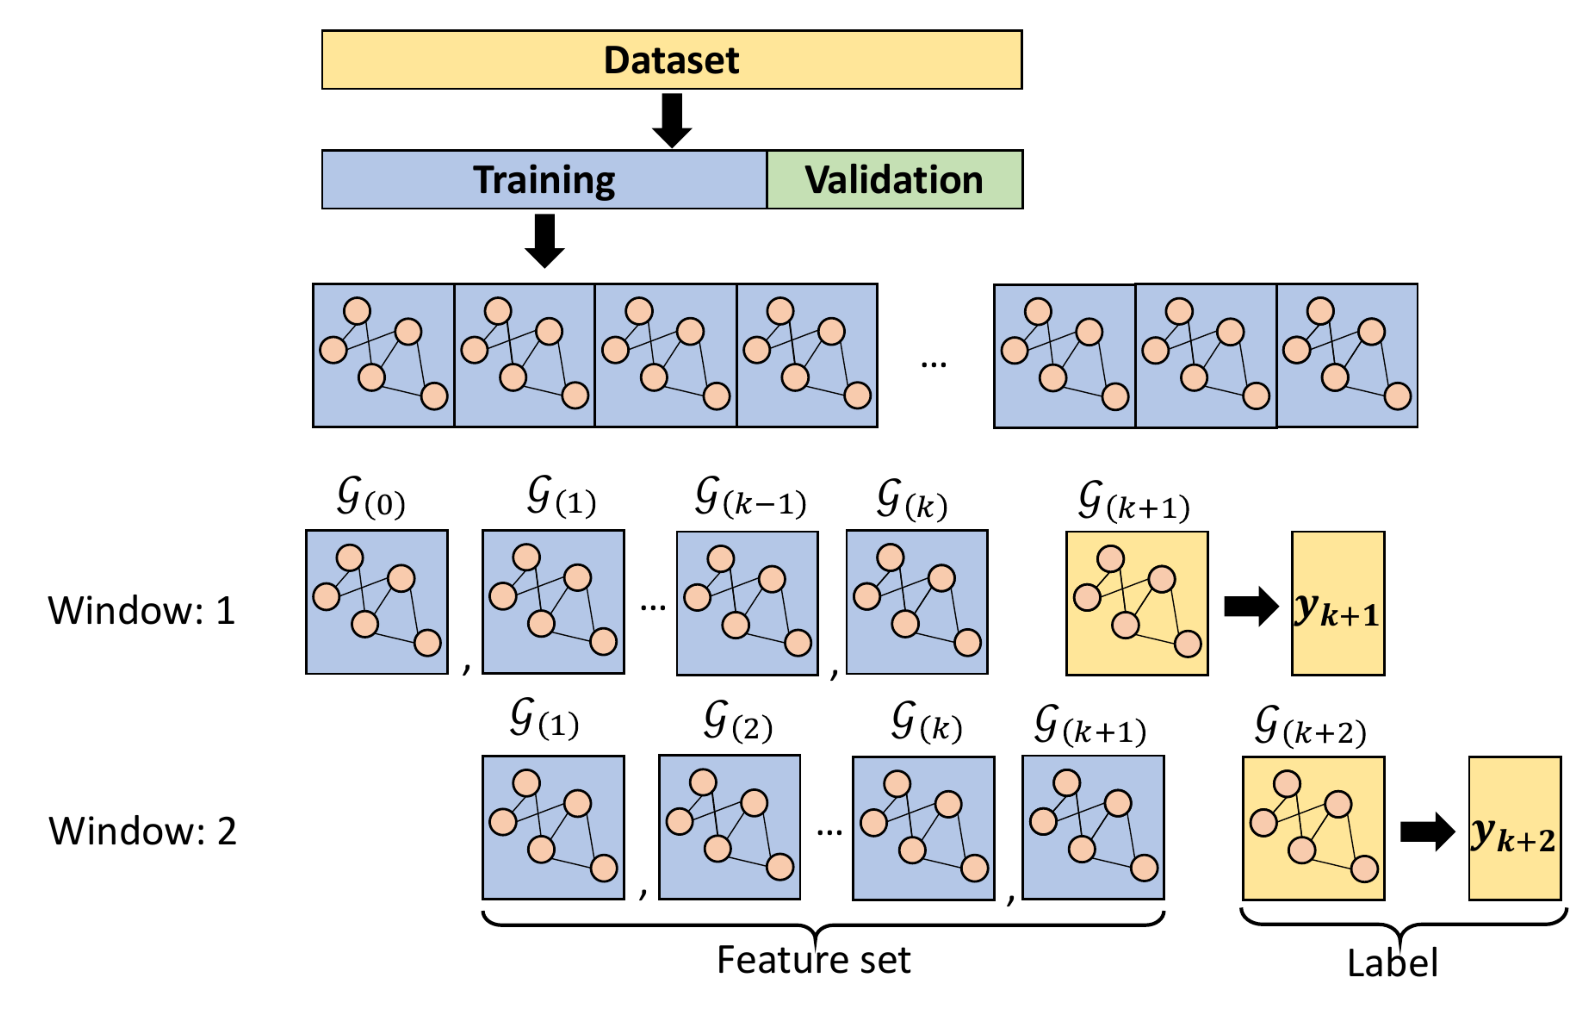

In [12]:
from pdf2image import convert_from_path
from IPython.display import display
from PIL import Image

# Convert the first page of the PDF to an image
pdf_path = "data_windowing.pdf"
pages = convert_from_path(pdf_path, dpi=200)  # You can specify DPI for quality


# Display the first page with custom figsize
plt.figure(figsize=(10, 15), dpi=200)  # Width, Height in inches
plt.imshow(pages[0])
plt.axis('off')  # Hide axis for a cleaner look
plt.show()

In [13]:
# Slice dataset into windows
Contract_train, y_margin_train, r_train, y_bench_train = utils.create_graph_windows(args, device,bench, train_dataset)
Contract_test,y_margin_test, r_test, y_bench_test = utils.create_graph_windows(args, device,bench, test_dataset)

n_samples: 100%|█████████████████████████| 4353/4353 [00:00<00:00, 22104.42it/s]


Now we have our dataset divided into train / test and properly windowed: 

- `Contract_train/_test.shape = (n_samples, lookback, num_nodes, max_num_contracts*6)` 
- `y_margin_train/_test.shape = (n_samples, num_nodes, steps_ahead)`
- `r_train/_test.shape = (n_samples, steps_ahead)`
- `y_bench_train/_test.shape = (n_samples, num_nodes, steps_ahead)`

In [14]:
print(f'Contract shape {Contract_train.shape}')
print(f'y_margin shape {y_margin_train.shape}')
print(f'r_train shape {r_train.shape}')
print(f'y_bench shape {y_bench_train.shape}')

Contract shape torch.Size([17435, 5, 5, 168])
y_margin shape torch.Size([17435, 5, 5])
r_train shape torch.Size([17435, 5])
y_bench shape torch.Size([17435, 5, 5])


Just to be extremely clear, we are left with a situatioation that has:

In [15]:
n_samples = len(train_dataset) - args.lookback - args.steps_ahead + 1
print('n_samples: ',n_samples)

n_samples:  17435


Before using the dataset, we create `.DataSplit` and `DataLoader` objects that take care of the iterations and the proper shapes the model needs to be fed with.

In [16]:
gclstm_train_dataset = dataset_managment.DataSplit(args, train_dataset)
gclstm_test_dataset = dataset_managment.DataSplit(args, test_dataset)
torch.manual_seed(0)
gclstm_train_loader = torch_geometric.loader.DataLoader(gclstm_train_dataset, batch_size=args.batch_size, shuffle=True)
gclstm_test_loader = torch_geometric.loader.DataLoader(gclstm_test_dataset, batch_size=args.batch_size, shuffle=True)

Then, we create a single `TensorDataset` out of the different datasets that we have previously windowed.

In [17]:
train_dataset = TensorDataset(Contract_train.to(device), y_margin_train.to(device), r_train.to(device))
test_dataset = TensorDataset(Contract_test.to(device), y_margin_test.to(device), r_test.to(device), y_margin_test.to(device))

And the corresponding `DataLoader`:

In [18]:
#Transform it into a dataloader
torch.manual_seed(0)
loader = DataLoader(train_dataset, shuffle=True, batch_size=args.batch_size)
loader_test = DataLoader(test_dataset, shuffle=True, batch_size = args.batch_size)

## Model definition



`CompleteModel` comprises both the `GC_LSTM` model and the single `PricingModule`, as explained in Sec. 5.3

In [19]:
#Define the model
mymodel = model_managment.CompleteModel(args).to(device) 

In channels:  1
Out channels:  15


## Training 

In [20]:

#Let's get towards the training:
criterion = nn.MSELoss()           #Loss function

#optimizer & scheduler
optimizer = torch.optim.Adam(mymodel.parameters(), lr = args.initial_lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[args.scheduler_milestone_frequency * i for i in range(args.scheduler_number_of_updates)], gamma=args.scheduler_gamma)

#Define an early stopping object
early_stopping = utils.EarlyStopping(args.patience)

#Define two lists to store training record
training_loss = []
validation_loss = []
lrs = []

In [21]:
#Define a tqdm loop to get a nice progress bar
loop = tqdm(range(args.n_epochs))

for epoch in loop:

    #Set model in training mode
    mymodel.train()

    #Perform an epoch of training
    train_loss = utils.do_epoch(args, mymodel, loader, gclstm_train_loader, criterion, optimizer)

    #Scheduler step
    scheduler.step()

    #Track the average over the batches
    training_loss.append(train_loss)
 
    #Validation every 50 epochs
    if epoch % args.validation_every ==0:

        with torch.no_grad():
            #Set the model in eval mod
            mymodel.eval()

            test_loss = utils.do_epoch(args, mymodel, loader_test, gclstm_test_loader, criterion, optimizer, training=False)

            #Track the average loss over the batches
            validation_loss.append(test_loss)

        #Check early stopping
        early_stopping(validation_loss[-1], mymodel)
        if early_stopping.early_stop:

            #Load the best set of parameters
            mymodel.load_state_dict(torch.load(f'temp_state_dict{mymodel.name}.pt'))
            print(f"Early stopping at epoch {epoch}.")
            break

    lrs.append(optimizer.param_groups[0]["lr"])
            
    #Give informations in the loop
    loop.set_postfix(loss = train_loss, val_loss = test_loss, best_val_loss = early_stopping.best_score, counter=early_stopping.counter, lr= lrs[-1])


  0%|          | 0/20000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Weights loading

In the `pretrained` folder you find several pre-trained weights corresponding to different model settings.
Files are named according to the following rule:
`temp_state_dict`+`num_nodes`+`lookback`+`batch_size`+`steps_ahead`+`.pt`
For instance, file:
`temp_state_dict555005.pt`
Refers to a situation comprising `num_nodes`=5, `lookback`=5, `batch_size`= 500 and `steps_ahead`=5

In [22]:
file_name = 'pretrained/temp_state_dict'+str(args.num_nodes)+str(args.lookback)+str(args.batch_size)+str(args.steps_ahead)+'.pt'
print('Loading weights on file: ',file_name)
mymodel.load_state_dict(torch.load(file_name, map_location=torch.device(args.device)))

Loading weights on file:  pretrained/temp_state_dict555005.pt


<All keys matched successfully>

## Prediction and evaluation

Now that we have fit the model, we incorporate in the dataset the benchmark that we havent used so far. This is because we want to build a fair comparison between our results and the best theoretical predictor.
**Please note** we set `batch_size` = 1 here for the prediction production.

In [27]:
train_dataset = TensorDataset(Contract_train.to(device), y_margin_train.to(device), r_train.to(device), y_bench_train.to(device))
test_dataset = TensorDataset(Contract_test.to(device), y_margin_test.to(device), r_test.to(device), y_bench_test.to(device))

#Transform it into a dataloader
torch.manual_seed(0)
loader = DataLoader(train_dataset, shuffle=False, batch_size=1)
loader_test = DataLoader(test_dataset, shuffle=False, batch_size = 1)

gclstm_train_loader = torch_geometric.loader.DataLoader(gclstm_train_dataset, batch_size=1, shuffle=False)
gclstm_test_loader = torch_geometric.loader.DataLoader(gclstm_test_dataset, batch_size=1, shuffle=False)

In [28]:
# #Get the predictions
print('Performing prediction')
train_margin_labels, train_benchmark, train_margin_predictions = utils.predictions(args, train_dataset, mymodel)
test_margin_labels, test_benchmark, test_margin_predictions = utils.predictions(args, test_dataset, mymodel)

Performing prediction


Prediction:   0%|                                     | 0/17435 [00:00<?, ?it/s]


AttributeError: 'CompleteModel' object has no attribute 'forward_pred'

In [29]:
def graph_predictions(args, model, loader, gc_loader):
    """
    Performs the model evalutation over the pytorch dataset

    Parameters
    ----------
    - dataset : `pytorch.Dataset`
        Dataset over which we want to base our prediction
    - model : `pytorch.nn.Module`
        model we want to use for the prediction
    """

    #Define a dataloader from the dataset without 


    #Define two tensors
    y_margin_preds = torch.zeros(len(loader), args.num_nodes, args.steps_ahead)
    y_margin_trues = torch.zeros(len(loader), args.num_nodes, args.steps_ahead)
    y_bench = torch.zeros(len(loader), args.num_nodes, args.steps_ahead)

    loop = tqdm(zip(gc_loader,loader), desc='Prediction')
    i_sample = 0
    
    for  batch_gc, (Contract_batch, y_margin_batch, r_batch, bench_batch) in loop:
        with torch.no_grad():

            intensity_embedding = model.gclstm(batch_gc)

            pred = model.lstm.forward_pred(Contract_batch, intensity_embedding.reshape(Contract_batch.shape[0], Contract_batch.shape[2], intensity_embedding.shape[1]), r_batch ).squeeze(0).cpu()

            print('pred.shape: ', pred.shape)
            print('y_margin_pred.shape', y_margin_preds[i_sample].shape)
            # FOCUS ON FIXED LEG
            y_margin_preds[i_sample] = pred
            y_margin_trues[i_sample]  = y_margin_batch.squeeze(0).cpu()
            y_bench[i_sample] = bench_batch.squeeze(0).cpu()
            i_sample +=1
            break
            
    return y_margin_trues.numpy(), y_margin_preds.numpy(), y_bench.numpy()

In [30]:
labels_test, preds_test, bench_test = graph_predictions(args, mymodel, loader_test, gclstm_test_loader)

Prediction: 0it [00:00, ?it/s]

pred.shape:  torch.Size([5, 5])
y_margin_pred.shape torch.Size([5, 5])


(4353, 5, 5)